# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression
## **Part b)** - Feed-Forward Neural Network

#### Program imports and defaults

In [4]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

#### Dataset setup

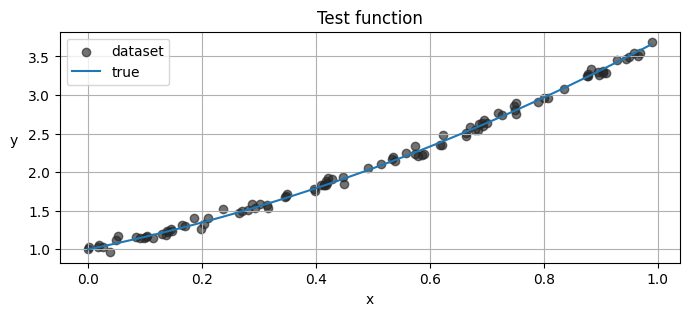

In [5]:
cases = ['1D','2D','Franke']
case_ = cases[0]
show = False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                          # Number of sample points

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
f = dataset.plot(labels=['Test function','x','y','dataset','true'])

### Feed-Forward Neural Network analysis


(100, 1)
(100, 1)
MSE:  0.0017215175152227912


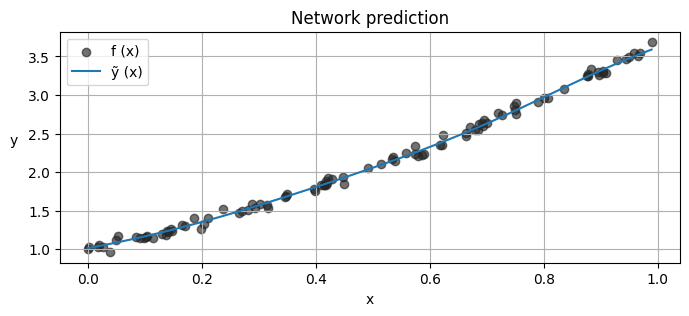

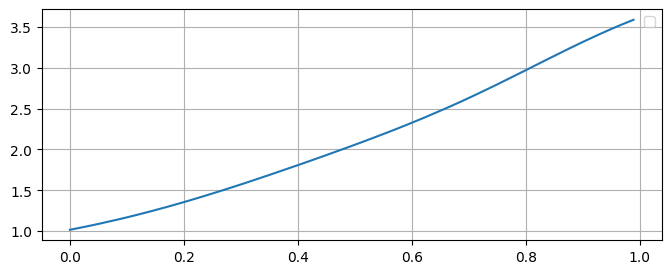

In [6]:
## 
poly_deg = 3
if case_ == '1D':
    target = dataset.target[0]
    x = dataset.x

else:
    target = dataset.target_f
    x = dataset.xf; y = dataset.yf


n_inputs,n_features = x.shape

'''print(n_inputs,n_features)
print(target.shape)
print(x[0,:].shape)'''


layer_output_sizes = [100,50,5,1]
act_funcs = [sigmoid,sigmoid,sigmoid,identity]
hidden_der = elementwise_grad(sigmoid,0); output_der = identity#elementwise_grad(identity,0)
cost_der = grad(mse_predict,0)
act_der   = [hidden_der,hidden_der,hidden_der,output_der]

network = FFNeuralNework(network_input_size=n_features,layer_output_size=layer_output_sizes,
                         multiple_input=True,
                         activation_functions=act_funcs,activation_derivatives=act_der,
                         cost_function=mse,cost_derivative=cost_der)

network.create_layers()

## Gradient Descent setup
eta = 0.01; gamma = 0.000001
batches = 10; epoch = 1000
decay_rms = 0.9
adagrad_mom = 0.001
ADAM_decay = [0.9, 0.99]

GDMethod = ADAM(eta,ADAM_decay) #MomentumGD(eta,gamma)

network.train_network(x,target,GDMethod,batches=batches,epochs=epoch)

final_predict = network.feed_forward(x)
print(final_predict.shape)

print(x.shape)
print('MSE: ',mse_predict(final_predict,target))
#plt.plot(x,final_predict)
#plt.scatter(x,target)
if case_ == '1D':
    plot1D(x,[target,final_predict],labels=['Network prediction','x','y','f (x)','ỹ (x)','',''])
    plot1D(x,final_predict)
else:
    plot2D()